# Project guidelines - CENTRO DE ACOPIO AGRÍCOLA

Your goal is to:

1. **Select the single most suitable municipality** based on a well-structured, reproducible spatial analysis.
2. **Within the selected municipality**, identify and map the **best local area** (polygon) where the project (crop, school, hospital, other facility) should be implemented.

Your final output will therefore include **two levels of analysis**:

- Level 1 — **Municipality ranking** based on multi-criteria analysis.
- Level 2 — **Intra-municipality spatial analysis** to identify the best location within the selected municipality.

## Import Libraries

In [133]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import contextily as ctx
import shapely

plt.rcParams['figure.figsize'] = (10, 8)

## Data preparation & CRS

- All spatial layers must be **re-projected to EPSG 9377**.
- Document any cleaning, pre-processing or CRS transformations you perform.


### Load & harmonise the data

We import the three source files, tidy a few columns and
ensure **every spatial layer** is projected to *MAGNA-SIRGAS Origen Nacional*
(**EPSG 9377**).  
The EVA table has no coordinates, but we rename its municipality code
to `cod_mun` for consistency.

In [134]:
# --- File paths  ---
root_folder=r"Datos"

SHAPE_MUN = root_folder+'/Municipios/municipios_colombia.shp'
SHAPE_RUNAP = root_folder+'/latest/runap.shp'
SHAPE_VIAS = root_folder+'/vias/vias.shp'
EVA_CSV   = root_folder+'/Evaluaciones_Agropecuarias_Municipales_EVA.csv'
EST_CSV   = root_folder+'/Catalogo_Estaciones_IDEAM.csv'


In [135]:
# Municipalities, protect areas and roats → GeoDataFrame 
gdf_mun = gpd.read_file(SHAPE_MUN).to_crs(epsg=9377)
gdf_runap = gpd.read_file(SHAPE_RUNAP).to_crs(epsg=9377)
gdf_vias = gpd.read_file(SHAPE_VIAS).to_crs(epsg=9377)

# EVA table, rename code column
eva = (pd.read_csv(EVA_CSV)
         .rename(columns={"CÓD. MUN.": "MPIO_CCDGO", "CÓD. \nDEP.": "DPTO_CCDGO"}))
eva["CULTIVO"] = eva["CULTIVO"].astype(str)      # ensure string

# IDEAM catalogue → GeoDataFrame (clean "(lat, lon)")
df_est = pd.read_csv(EST_CSV)
coords = (df_est["Ubicación"]
            .str.strip("()")
            .str.split(",", expand=True)
            .astype(float))
df_est["lat"], df_est["lon"] = coords[0], coords[1]

gdf_est = gpd.GeoDataFrame(
    df_est,
    geometry=gpd.points_from_xy(df_est["lon"], df_est["lat"]),
    crs="EPSG:4326"
).to_crs(epsg=9377)

print(f"{len(gdf_mun):,} municipalities • {len(gdf_est):,} stations • "
      f"{len(eva):,} EVA rows")


#Homogenise municipalities codes
gdf_mun["MPIO_CCDGO"] = gdf_mun["Codigo_Mun"].astype(str).str.zfill(5)
gdf_mun["DPTO_CCDGO"] = gdf_mun["DPTO_CCDGO"].astype(str).str.zfill(2)
eva["MPIO_CCDGO"]        = eva["MPIO_CCDGO"].astype(str).str.zfill(5)

print(gdf_mun)

1,122 municipalities • 8,973 stations • 206,068 EVA rows
     DPTO_CCDGO MPIO_CCDGO              MPIO_CNMBR MPIO_CDPMP  VERSION  \
0            18      18001               FLORENCIA      18001     2018   
1            18      18029                 ALBANIA      18029     2018   
2            18      18094  BELÉN DE LOS ANDAQUÍES      18094     2018   
3            18      18247             EL DONCELLO      18247     2018   
4            18      18256               EL PAUJÍL      18256     2018   
...         ...        ...                     ...        ...      ...   
1117         25      25290              FUSAGASUGÁ      25290     2018   
1118         25      25662     SAN JUAN DE RIOSECO      25662     2018   
1119         73      73349                   HONDA      73349     2018   
1120         05      05631                SABANETA       5631     2018   
1121         05      05380             LA ESTRELLA       5380     2018   

              AREA   LATITUD   LONGITUD  STCTNENCUE  S

### Municipality selection

- Select an appropriate subset of municipalities an agricultural collection center.

In [136]:
# Crear tabla única de departamentos con código y nombre
deptos = eva[["DPTO_CCDGO", "DEPARTAMENTO"]].drop_duplicates()
deptos["DPTO_CCDGO"] = deptos["DPTO_CCDGO"].astype(str).str.zfill(2)

# añadir nombre del departamento a los municipios
gdf_mun = gdf_mun.merge(deptos, on="DPTO_CCDGO", how="left")
print(gdf_mun)

     DPTO_CCDGO MPIO_CCDGO              MPIO_CNMBR MPIO_CDPMP  VERSION  \
0            18      18001               FLORENCIA      18001     2018   
1            18      18029                 ALBANIA      18029     2018   
2            18      18094  BELÉN DE LOS ANDAQUÍES      18094     2018   
3            18      18247             EL DONCELLO      18247     2018   
4            18      18256               EL PAUJÍL      18256     2018   
...         ...        ...                     ...        ...      ...   
1117         25      25290              FUSAGASUGÁ      25290     2018   
1118         25      25662     SAN JUAN DE RIOSECO      25662     2018   
1119         73      73349                   HONDA      73349     2018   
1120         05      05631                SABANETA       5631     2018   
1121         05      05380             LA ESTRELLA       5380     2018   

              AREA   LATITUD   LONGITUD  STCTNENCUE  STP3_1_SI  ...  \
0     2.547638e+09  1.749139 -75.558239 

In [137]:
# Filtrar municipios amazónicos
departamentos_amazonia = ["AMAZONAS", "CAQUETA", "GUAVIARE", "GUAINIA", "PUTUMAYO", "VAUPES"]
gdf_mun_amz = gdf_mun[gdf_mun["DEPARTAMENTO"].isin(departamentos_amazonia)].copy()
print(gdf_mun_amz)

    DPTO_CCDGO MPIO_CCDGO              MPIO_CNMBR MPIO_CDPMP  VERSION  \
0           18      18001               FLORENCIA      18001     2018   
1           18      18029                 ALBANIA      18029     2018   
2           18      18094  BELÉN DE LOS ANDAQUÍES      18094     2018   
3           18      18247             EL DONCELLO      18247     2018   
4           18      18256               EL PAUJÍL      18256     2018   
5           18      18410            LA MONTAÑITA      18410     2018   
6           18      18460                   MILÁN      18460     2018   
7           18      18479                 MORELIA      18479     2018   
8           18      18610     SAN JOSÉ DEL FRAGUA      18610     2018   
9           18      18860              VALPARAÍSO      18860     2018   
10          18      18150    CARTAGENA DEL CHAIRÁ      18150     2018   
11          18      18753  SAN VICENTE DEL CAGUÁN      18753     2018   
12          18      18756                  SOLANO  

- Calculate densidad poblacional

In [138]:
# calcular densidad poblacional por municipio
gdf_mun_amz['area_km2'] = gdf_mun_amz.area / 1e6
gdf_mun_amz["pop_density_km2"] = gdf_mun_amz["STP27_PERS"]/ gdf_mun_amz['area_km2']

print(gdf_mun_amz)

    DPTO_CCDGO MPIO_CCDGO              MPIO_CNMBR MPIO_CDPMP  VERSION  \
0           18      18001               FLORENCIA      18001     2018   
1           18      18029                 ALBANIA      18029     2018   
2           18      18094  BELÉN DE LOS ANDAQUÍES      18094     2018   
3           18      18247             EL DONCELLO      18247     2018   
4           18      18256               EL PAUJÍL      18256     2018   
5           18      18410            LA MONTAÑITA      18410     2018   
6           18      18460                   MILÁN      18460     2018   
7           18      18479                 MORELIA      18479     2018   
8           18      18610     SAN JOSÉ DEL FRAGUA      18610     2018   
9           18      18860              VALPARAÍSO      18860     2018   
10          18      18150    CARTAGENA DEL CHAIRÁ      18150     2018   
11          18      18753  SAN VICENTE DEL CAGUÁN      18753     2018   
12          18      18756                  SOLANO  

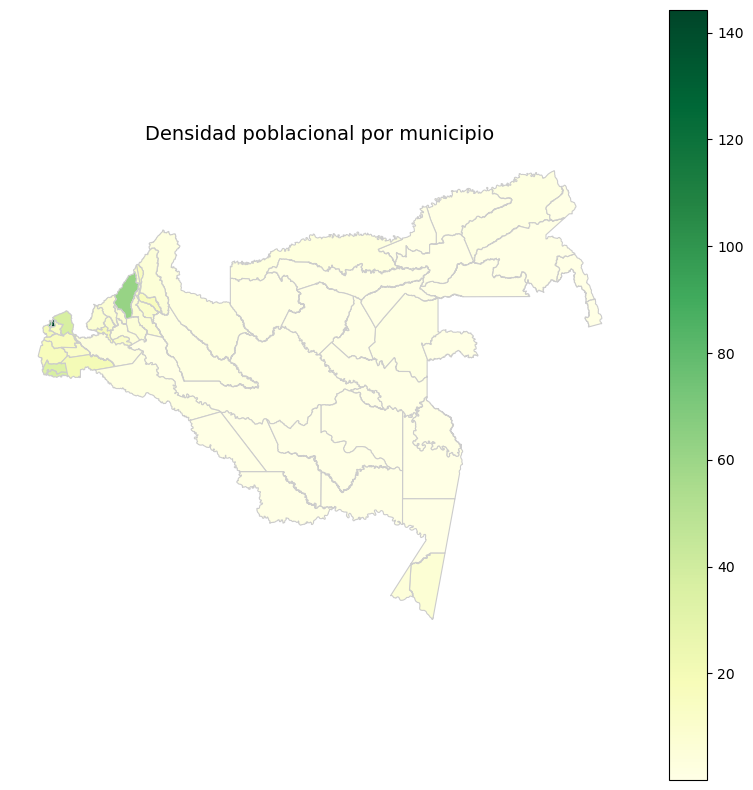

In [139]:
# Crear el mapa
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Dibujar el mapa de coropletas
gdf_mun_amz.plot(column="pop_density_km2", 
                 cmap="YlGn", 
                 linewidth=0.8, 
                 edgecolor="0.8", 
                 legend=True, 
                 ax=ax)
# 4. Títulos y estilo
ax.set_title("Densidad poblacional por municipio", fontsize=14)
ax.axis("off")

plt.show()

- Calculate road density by municipality

In [140]:
# Intersectar las vias con los municipios -> GDF
vias_en_mun = gpd.overlay(gdf_vias, gdf_mun_amz, how="intersection")

# Calcular longintud de las vías
vias_en_mun["long_m"] = vias_en_mun.geometry.length

# Agrupar por municipio
long_vias = vias_en_mun.groupby("MPIO_CCDGO")[["long_m"]].sum().reset_index()

# Calcular área de cada municipio (en m²)
gdf_mun_amz["area_m2"] = gdf_mun_amz.geometry.area

long_vias = long_vias.rename(columns={"long_m": "long_m_vias"})

# Hacer merge de la longitud con el GDF de municipios
gdf_mun_amz = gdf_mun_amz.merge(long_vias, on="MPIO_CCDGO", how="left")
gdf_mun_amz["long_m_vias"] = gdf_mun_amz["long_m_vias"].fillna(0) # Rellenar con 0 los municipios sin vías

# Calcular densidad de vías (por km²)
gdf_mun_amz["vias_km2"] = gdf_mun_amz["long_m_vias"] / (gdf_mun_amz["area_m2"] / 1e6)
# print(gdf_mun_amz)
gdf_mun_amz

,DPTO_CCDGO,MPIO_CCDGO,MPIO_CNMBR,MPIO_CDPMP,VERSION,AREA,LATITUD,LONGITUD,STCTNENCUE,STP3_1_SI,...,Shape_Leng,Shape_Area,Codigo_Mun,geometry,DEPARTAMENTO,area_km2,pop_density_km2,area_m2,long_m_vias,vias_km2
0,18,18001,FLORENCIA,18001,2018,2.547638e+09,1.749139,-75.558239,71877.0,32.0,...,2.942508,0.206928,18001,"POLYGON ((4730856.146 1800689.038, 4730891.264...",CAQUETA,2546.958298,61.559312,2.546958e+09,95033.941548,37.312720
1,18,18029,ALBANIA,18029,2018,4.141221e+08,1.227865,-75.882327,2825.0,24.0,...,1.112829,0.033618,18029,"POLYGON ((4677933.827 1709133.846, 4677934.064...",CAQUETA,414.100691,10.900730,4.141007e+08,1235.940605,2.984638
2,18,18094,BELÉN DE LOS ANDAQUÍES,18094,2018,1.191619e+09,1.500923,-75.875645,4243.0,54.0,...,2.234657,0.096745,18094,"POLYGON ((4690015.614 1751610.86, 4690005.125 ...",CAQUETA,1191.551389,7.616121,1.191551e+09,22778.780336,19.116910
3,18,18247,EL DONCELLO,18247,2018,1.106076e+09,1.791386,-75.193944,8809.0,0.0,...,3.154370,0.089867,18247,"POLYGON ((4737450.122 1814755.048, 4737477.663...",CAQUETA,1105.514836,16.078482,1.105515e+09,26060.640601,23.573307
4,18,18256,EL PAUJÍL,18256,2018,1.234734e+09,1.617746,-75.234043,5795.0,0.0,...,3.529316,0.100309,18256,"POLYGON ((4736905.653 1802381.382, 4737650.731...",CAQUETA,1234.140645,10.544989,1.234141e+09,18564.392925,15.042364
5,18,18410,LA MONTAÑITA,18410,2018,1.701061e+09,1.302860,-75.235727,5113.0,15.0,...,3.402939,0.138174,18410,"POLYGON ((4732709.921 1753612.108, 4733113.179...",CAQUETA,1700.246212,7.133085,1.700246e+09,23667.998363,13.920336
6,18,18460,MILÁN,18460,2018,1.220576e+09,1.146693,-75.386648,3462.0,363.0,...,1.863197,0.099128,18460,"POLYGON ((4733752.837 1708152.838, 4733760.752...",CAQUETA,1220.112914,6.152709,1.220113e+09,0.000000,0.000000
7,18,18479,MORELIA,18479,2018,4.624796e+08,1.382996,-75.673811,1907.0,0.0,...,1.518688,0.037554,18479,"POLYGON ((4691680.95 1732813.818, 4691743.086 ...",CAQUETA,462.391875,7.244937,4.623919e+08,6895.323345,14.912293
8,18,18610,SAN JOSÉ DEL FRAGUA,18610,2018,1.304769e+09,1.304702,-76.110006,5756.0,83.0,...,2.040837,0.105893,18610,"POLYGON ((4647662.862 1733719.27, 4647740.381 ...",CAQUETA,1304.898166,8.708726,1.304898e+09,9972.833257,7.642614
9,18,18860,VALPARAÍSO,18860,2018,1.330210e+09,1.061292,-75.627048,3958.0,0.0,...,2.313848,0.108006,18860,"POLYGON ((4696163.446 1704876.824, 4696219.718...",CAQUETA,1329.917002,4.573218,1.329917e+09,1071.303575,0.805542


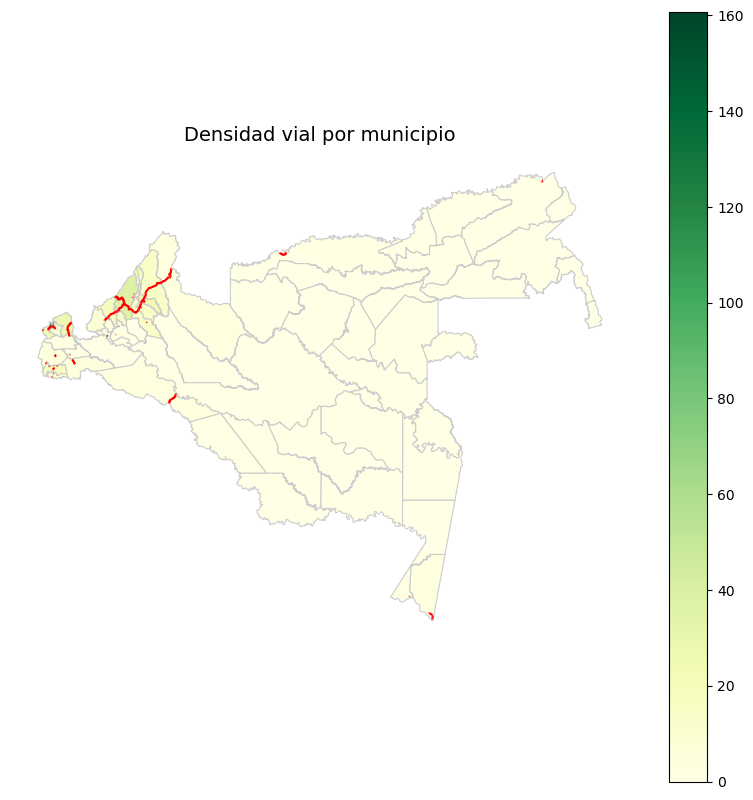

In [141]:
# Crear el mapa
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Dibujar el mapa de coropletas
gdf_mun_amz.plot(column="vias_km2", 
                 cmap="YlGn", 
                 linewidth=0.8, 
                 edgecolor="0.8", 
                 legend=True, 
                 ax=ax)
vias_en_mun.plot(ax=ax, edgecolor='red');
# 4. Títulos y estilo
ax.set_title("Densidad vial por municipio", fontsize=14)
ax.axis("off")

plt.show()

- Evaluate presence of protected areas (topology)

In [142]:
# spatial intersection
interseccion_runap = gpd.overlay(gdf_mun_amz, gdf_runap, how='intersection')

# Calculate the area of the intersection
interseccion_runap["area_runap_km2"] = interseccion_runap.geometry.area/ 1e6

# Groupby municipality and add the protected areas
runap_por_mun = interseccion_runap.groupby("MPIO_CCDGO")[["area_runap_km2"]].sum().reset_index()

# Join to GeoDataFrame of municipalities
gdf_mun_amz = gdf_mun_amz.merge(runap_por_mun, on="MPIO_CCDGO", how="left").fillna(0) # Rellenar con 0 los municipios sin runap

# Percentage of runap by municipality
gdf_mun_amz["proporcion_runap"] = gdf_mun_amz["area_runap_km2"] / (gdf_mun_amz["area_m2"] / 1e6)
print(gdf_mun_amz)

/tmp/ipykernel_43/4271836756.py:2: UserWarning: `keep_geom_type=True` in overlay resulted in 1728 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  interseccion_runap = gpd.overlay(gdf_mun_amz, gdf_runap, how='intersection')


   DPTO_CCDGO MPIO_CCDGO              MPIO_CNMBR MPIO_CDPMP  VERSION  \
0          18      18001               FLORENCIA      18001     2018   
1          18      18029                 ALBANIA      18029     2018   
2          18      18094  BELÉN DE LOS ANDAQUÍES      18094     2018   
3          18      18247             EL DONCELLO      18247     2018   
4          18      18256               EL PAUJÍL      18256     2018   
5          18      18410            LA MONTAÑITA      18410     2018   
6          18      18460                   MILÁN      18460     2018   
7          18      18479                 MORELIA      18479     2018   
8          18      18610     SAN JOSÉ DEL FRAGUA      18610     2018   
9          18      18860              VALPARAÍSO      18860     2018   
10         18      18150    CARTAGENA DEL CHAIRÁ      18150     2018   
11         18      18753  SAN VICENTE DEL CAGUÁN      18753     2018   
12         18      18756                  SOLANO      18756     

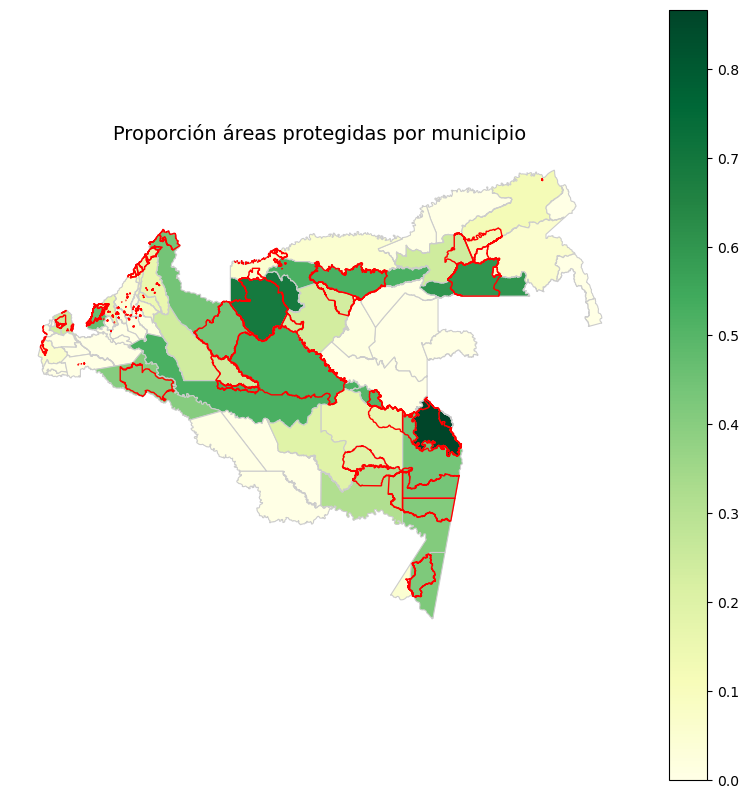

In [143]:
# Crear el mapa
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Dibujar el mapa de coropletas
gdf_mun_amz.plot(column="proporcion_runap", 
                 cmap="YlGn", 
                 linewidth=0.8, 
                 edgecolor="0.8", 
                 legend=True, 
                 ax=ax)
interseccion_runap.plot(ax=ax, color='None', edgecolor='red');
# 4. Títulos y estilo
ax.set_title("Proporción áreas protegidas por municipio", fontsize=14)
ax.axis("off")

plt.show()

-  Calculate number of IDEAM stations by municipality

In [144]:
# stations within each municipality
est_en_mun = gpd.sjoin(gdf_est, gdf_mun_amz, how="inner", predicate="within")

# Count stations by municipality
conteo_est = est_en_mun.groupby("MPIO_CCDGO").size().reset_index(name="n_estaciones")

# Merge with municipalities
gdf_mun_amz = gdf_mun_amz.merge(conteo_est, on="MPIO_CCDGO", how="left")
gdf_mun_amz["n_estaciones"] = gdf_mun_amz["n_estaciones"].fillna(0)
print(gdf_mun_amz)

   DPTO_CCDGO MPIO_CCDGO              MPIO_CNMBR MPIO_CDPMP  VERSION  \
0          18      18001               FLORENCIA      18001     2018   
1          18      18029                 ALBANIA      18029     2018   
2          18      18094  BELÉN DE LOS ANDAQUÍES      18094     2018   
3          18      18247             EL DONCELLO      18247     2018   
4          18      18256               EL PAUJÍL      18256     2018   
5          18      18410            LA MONTAÑITA      18410     2018   
6          18      18460                   MILÁN      18460     2018   
7          18      18479                 MORELIA      18479     2018   
8          18      18610     SAN JOSÉ DEL FRAGUA      18610     2018   
9          18      18860              VALPARAÍSO      18860     2018   
10         18      18150    CARTAGENA DEL CHAIRÁ      18150     2018   
11         18      18753  SAN VICENTE DEL CAGUÁN      18753     2018   
12         18      18756                  SOLANO      18756     

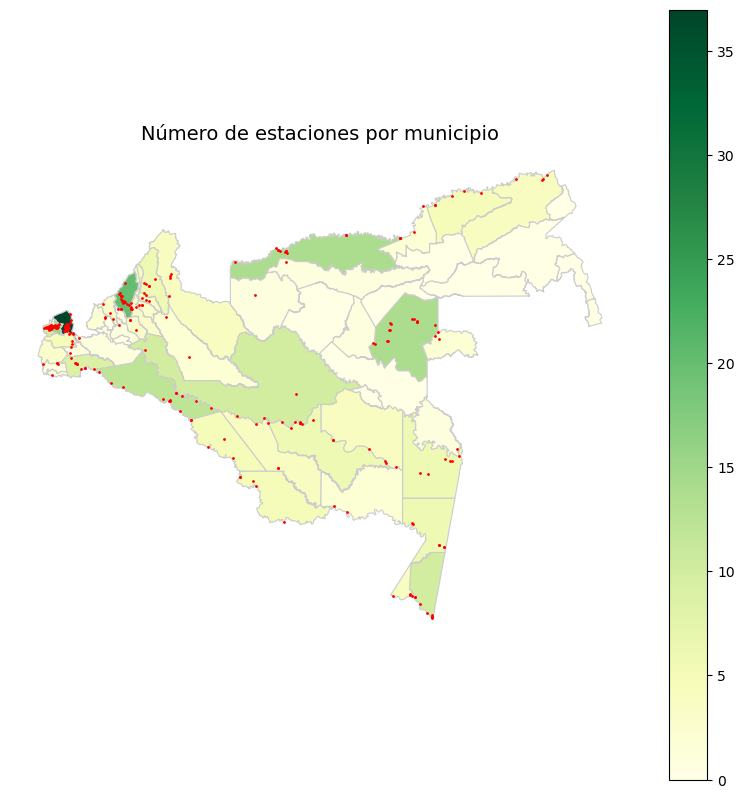

In [145]:
# Crear el mapa
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Dibujar el mapa de coropletas
gdf_mun_amz.plot(column="n_estaciones", 
                 cmap="YlGn", 
                 linewidth=0.8, 
                 edgecolor="0.8", 
                 legend=True, 
                 ax=ax)
est_en_mun.plot(ax=ax, color="red", markersize=1);
# 4. Títulos y estilo
ax.set_title("Número de estaciones por municipio", fontsize=14)
ax.axis("off")

plt.show()

- calculate productividad y variedad

In [146]:
# produccion por municipio
prod_mun = eva.groupby("MPIO_CCDGO")[["Producción\n(t)"]].sum().reset_index()

# variedad de cultivos por munnicipio
n_cultivos = eva.groupby("MPIO_CCDGO")["CULTIVO"].nunique().reset_index()
n_cultivos.columns = ["MPIO_CCDGO", "n_cultivos"]

# Unir resultados
prod_mun = prod_mun.merge(n_cultivos, on="MPIO_CCDGO", how="left").fillna(0)
gdf_mun_amz = gdf_mun_amz.merge(prod_mun, on="MPIO_CCDGO", how="left").fillna(0)

print(gdf_mun_amz)


   DPTO_CCDGO MPIO_CCDGO              MPIO_CNMBR MPIO_CDPMP  VERSION  \
0          18      18001               FLORENCIA      18001     2018   
1          18      18029                 ALBANIA      18029     2018   
2          18      18094  BELÉN DE LOS ANDAQUÍES      18094     2018   
3          18      18247             EL DONCELLO      18247     2018   
4          18      18256               EL PAUJÍL      18256     2018   
5          18      18410            LA MONTAÑITA      18410     2018   
6          18      18460                   MILÁN      18460     2018   
7          18      18479                 MORELIA      18479     2018   
8          18      18610     SAN JOSÉ DEL FRAGUA      18610     2018   
9          18      18860              VALPARAÍSO      18860     2018   
10         18      18150    CARTAGENA DEL CHAIRÁ      18150     2018   
11         18      18753  SAN VICENTE DEL CAGUÁN      18753     2018   
12         18      18756                  SOLANO      18756     

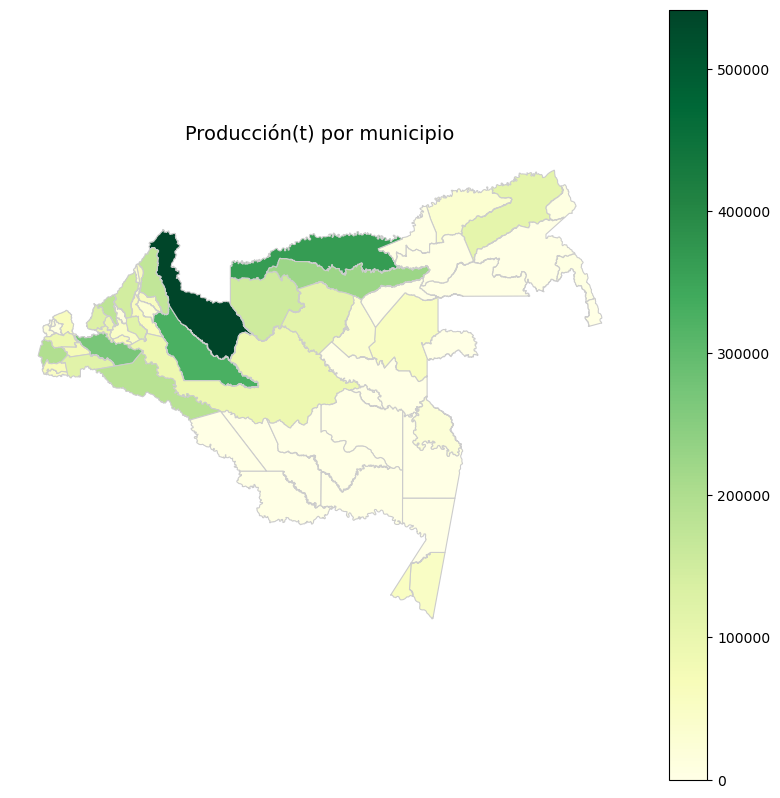

In [147]:
# Crear el mapa
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Dibujar el mapa de coropletas
gdf_mun_amz.plot(column="Producción\n(t)", 
                 cmap="YlGn", 
                 linewidth=0.8, 
                 edgecolor="0.8", 
                 legend=True, 
                 ax=ax)

# 4. Títulos y estilo
ax.set_title("Producción(t) por municipio", fontsize=14)
ax.axis("off")

plt.show()

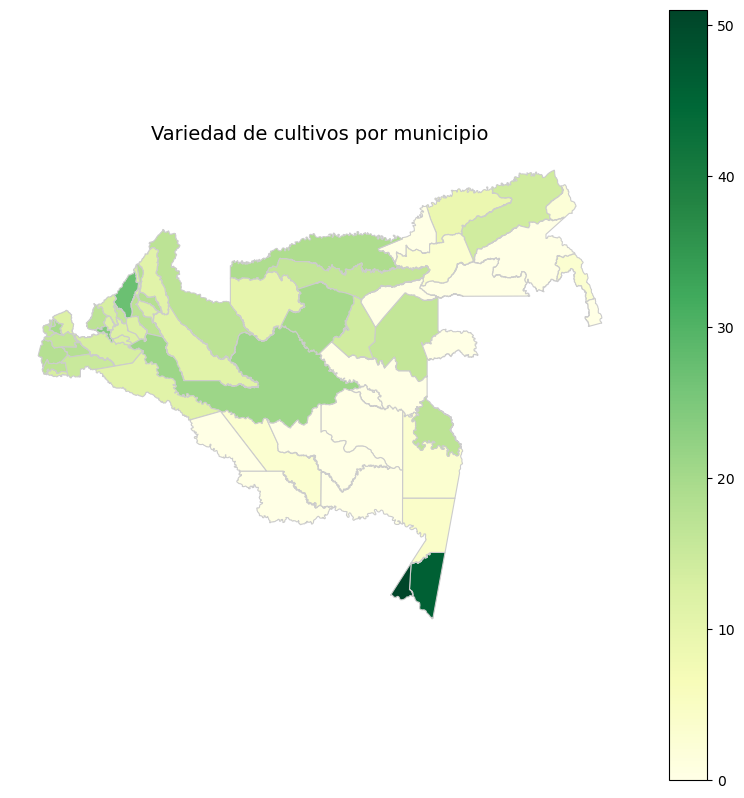

In [148]:
# Crear el mapa
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Dibujar el mapa de coropletas
gdf_mun_amz.plot(column="n_cultivos", 
                 cmap="YlGn", 
                 linewidth=0.8, 
                 edgecolor="0.8", 
                 legend=True, 
                 ax=ax)

# 4. Títulos y estilo
ax.set_title("Variedad de cultivos por municipio", fontsize=14)
ax.axis("off")

plt.show()

# Criteria used to define an optimal municipality
- Road density (vias_km2) - Higher is better.

- Proportion of protected areas (proportion_runap) - Lower is better.

- Number of weather stations (n_stations) - Higher is better.

- Total agricultural production (production) - Higher is better.

- Crop diversity (n_crops) - Higher is better.

In [149]:
from sklearn.preprocessing import MinMaxScaler

# Selecciona las columnas relevantes
criterios = gdf_mun_amz[["vias_km2", "proporcion_runap", "n_estaciones", "Producción\n(t)", "n_cultivos","pop_density_km2"]].copy()

# Invertir la proporción de runap porque menor es mejor
criterios["inv_runap"] = 1 - criterios["proporcion_runap"]

# Escalar los criterios
scaler = MinMaxScaler()
criterios_normalizados = scaler.fit_transform(criterios[["vias_km2", "inv_runap", "n_estaciones", "Producción\n(t)", "n_cultivos","pop_density_km2"]])

# Convertir en GeoDataFrame y le damos nombres
criterios_norm_df = pd.DataFrame(criterios_normalizados, columns=["C_vias", "C_runap", "C_estaciones", "C_Produccion", "C_cultivos","C_poblacion"])

# Añadimos el índice de municipio
criterios_norm_df["MPIO_CCDGO"] = gdf_mun_amz["MPIO_CCDGO"].values

# Unir al GeoDataFrame original
gdf_criterios = gdf_mun_amz.merge(criterios_norm_df, on="MPIO_CCDGO")

print(gdf_criterios)

   DPTO_CCDGO MPIO_CCDGO              MPIO_CNMBR MPIO_CDPMP  VERSION  \
0          18      18001               FLORENCIA      18001     2018   
1          18      18029                 ALBANIA      18029     2018   
2          18      18094  BELÉN DE LOS ANDAQUÍES      18094     2018   
3          18      18247             EL DONCELLO      18247     2018   
4          18      18256               EL PAUJÍL      18256     2018   
5          18      18410            LA MONTAÑITA      18410     2018   
6          18      18460                   MILÁN      18460     2018   
7          18      18479                 MORELIA      18479     2018   
8          18      18610     SAN JOSÉ DEL FRAGUA      18610     2018   
9          18      18860              VALPARAÍSO      18860     2018   
10         18      18150    CARTAGENA DEL CHAIRÁ      18150     2018   
11         18      18753  SAN VICENTE DEL CAGUÁN      18753     2018   
12         18      18756                  SOLANO      18756     

- Asignar pesos por criterio

In [150]:
# Pesos 
pesos = {
    "P_vias": 0.8,
    "P_runap": 0.5,
    "P_estaciones": 0.6,
    "P_Produccion": 0.9,
    "P_cultivos": 0.5,
    "P_poblacion": 1
}

# Calcular puntaje menor
gdf_criterios["puntaje_total"] = (
    gdf_criterios["C_vias"] * pesos["P_vias"] +
    gdf_criterios["C_runap"] * pesos["P_runap"] +
    gdf_criterios["C_estaciones"] * pesos["P_estaciones"] +
    gdf_criterios["C_Produccion"] * pesos["P_Produccion"] +
    gdf_criterios["C_cultivos"] * pesos["P_cultivos"] +
    gdf_criterios["C_poblacion"] * pesos["P_poblacion"]
)

print(gdf_criterios)

   DPTO_CCDGO MPIO_CCDGO              MPIO_CNMBR MPIO_CDPMP  VERSION  \
0          18      18001               FLORENCIA      18001     2018   
1          18      18029                 ALBANIA      18029     2018   
2          18      18094  BELÉN DE LOS ANDAQUÍES      18094     2018   
3          18      18247             EL DONCELLO      18247     2018   
4          18      18256               EL PAUJÍL      18256     2018   
5          18      18410            LA MONTAÑITA      18410     2018   
6          18      18460                   MILÁN      18460     2018   
7          18      18479                 MORELIA      18479     2018   
8          18      18610     SAN JOSÉ DEL FRAGUA      18610     2018   
9          18      18860              VALPARAÍSO      18860     2018   
10         18      18150    CARTAGENA DEL CHAIRÁ      18150     2018   
11         18      18753  SAN VICENTE DEL CAGUÁN      18753     2018   
12         18      18756                  SOLANO      18756     

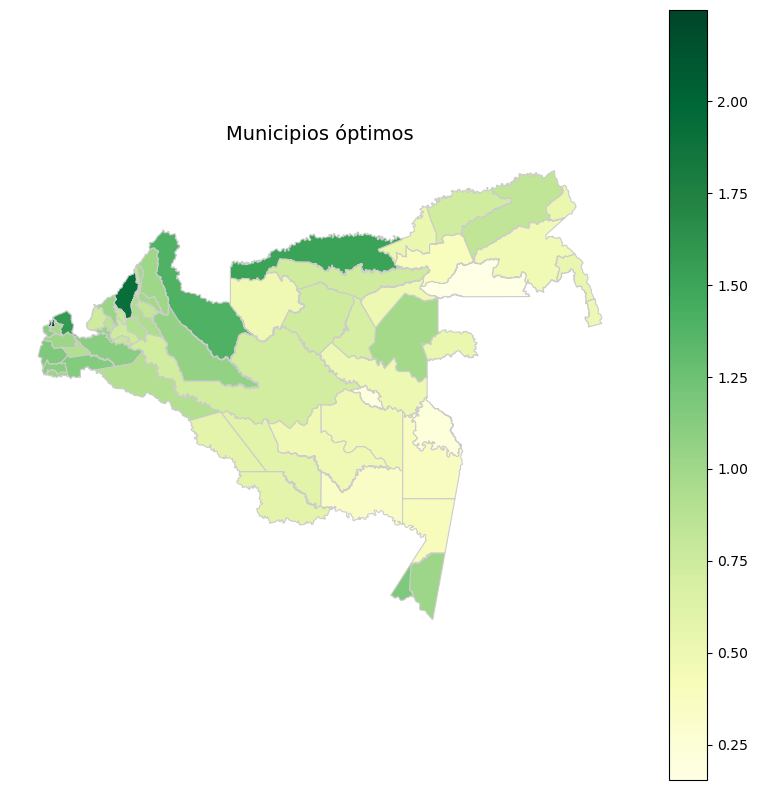

In [151]:
# Crear el mapa
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Dibujar el mapa de coropletas
gdf_criterios.plot(column="puntaje_total", 
                 cmap="YlGn", 
                 linewidth=0.8, 
                 edgecolor="0.8", 
                 legend=True, 
                 ax=ax)
# 4. Títulos y estilo
ax.set_title("Municipios óptimos", fontsize=14)
ax.axis("off")

plt.show()

- Seleccionar grupo de municipios más aptos

In [152]:
mun_opt = gdf_criterios.sort_values(by='puntaje_total', ascending=False).head(1)

print(mun_opt)

   DPTO_CCDGO MPIO_CCDGO MPIO_CNMBR MPIO_CDPMP  VERSION          AREA  \
19         86      86749   SIBUNDOY      86749     2018  9.773462e+07   

     LATITUD   LONGITUD  STCTNENCUE  STP3_1_SI  ...  n_estaciones  \
19  1.228747 -76.913076      7446.0      432.0  ...           4.0   

    Producción\n(t)  n_cultivos    C_vias  C_runap  C_estaciones  \
19          20565.0        18.0  0.591138      1.0      0.108108   

    C_Produccion  C_cultivos  C_poblacion  puntaje_total  
19      0.037932    0.352941          1.0       2.248384  

[1 rows x 110 columns]


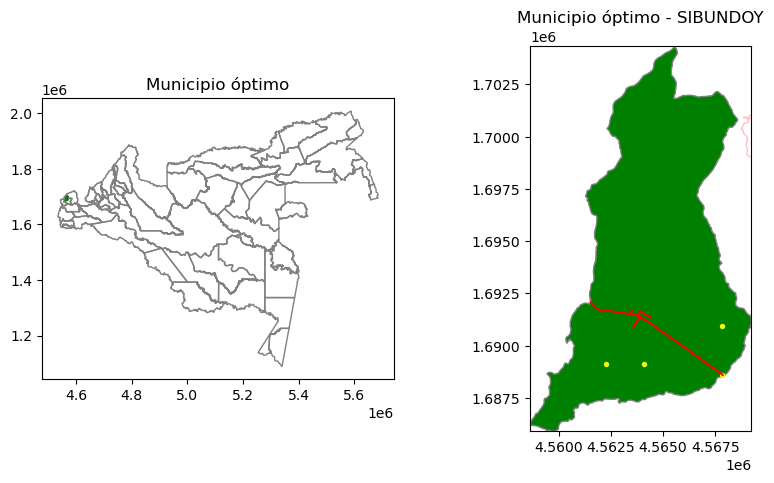

In [173]:
vias_mun = gpd.overlay(vias_en_mun, mun_opt, how='intersection')
est_mun = gpd.overlay(est_en_mun, mun_opt, how='intersection')

# Visualizar municipio más óptimmo
fig, (ax1, ax2)= plt.subplots(1,2, figsize=(10,5))

gdf_criterios.plot(ax=ax1, color="none", edgecolor="gray", figsize=(5, 5))
mun_opt.plot(ax=ax1, color="green", edgecolor="green", figsize=(5, 5))

# 4. Títulos y estilo
ax1.set_title("Municipio óptimo")
# plt.show()

mun_opt.plot(ax=ax2, color="green", edgecolor="grey", figsize=(5, 5))
est_mun.plot(ax=ax2, color="yellow", markersize=8);
interseccion_runap.plot(ax=ax2, color='None', edgecolor='pink');
vias_mun.plot(ax=ax2, edgecolor='red');

# Establecer límites del mapa con base en el municipio óptimo
ax2.set_xlim(mun_opt.total_bounds[0], mun_opt.total_bounds[2])
ax2.set_ylim(mun_opt.total_bounds[1], mun_opt.total_bounds[3])

ax2.set_title("Municipio óptimo - SIBUNDOY")
plt.show()

## Core analysis steps — Level 2: Best location within selected municipality

In [ ]:

# Parámetros de grilla
res = 1000  # en metros

# Bounding box del municipio
minx, miny, maxx, maxy = municipio_optimo.total_bounds
cols = list(np.arange(minx, maxx, res))
rows = list(np.arange(miny, maxy, res))
polygons = [box(x, y, x+res, y+res) for x in cols for y in rows]

grid = gpd.GeoDataFrame({'geometry': polygons}, crs=municipio_optimo.crs)
grid = gpd.overlay(grid, municipio_optimo, how='intersection')